In [630]:
import math
import torch
import gpytorch
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [631]:
#First load data from xarray
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')

# Enter coordinates 
coords = (29, -90)   #NOLA

# Grab the approximate chunk for provided coords
area_approx = rechunked.sea_level.sel(xt_ocean=coords[1], yt_ocean=coords[0], method="nearest")

# Set up the DataArray with data as the sea level of the approximate area, and time as it's dimension
coords_dict = {'time': sea_level_picontrol['time']}
area_sea_level = xr.DataArray(area_approx, dims=('time'), coords=coords_dict)

# Turn Data to tensors
time_int = cf_units.date2num(area_sea_level.time,'days since 0185-01-01 12:00:00' , calendar='julian')

In [632]:
def set_x_and_y(indexes, time, sea_level):
    """
    Input: array of indexes
    Output: Tensors for x and y (either train or test)
    """
    x = []
    y = [] 

    for i in indexes:
        x.append(time[i])
        y.append(sea_level[i])
        
    x = (np.array(x)).astype(float)
    y = (np.array(y)).astype(float)
        
    x = torch.FloatTensor(x).squeeze()
    y = torch.FloatTensor(y).squeeze()
    
    return x, y
        
def select_training_gaps(data_size, gap_size, time, sea_level):
    """
    Input: sea_level data
    Output: Tensors with x_train y_train, x_test, and y_test
    """
    
    # Randomly choose points for training, the rest for testing
    indexes = list(range(0, data_size))
    training_indexes = np.arange(0, data_size-gap_size).reshape(-1, 1)
    testing_indexes = np.setdiff1d(indexes, training_indexes).reshape(-1, 1)
    
    x_train, y_train = set_x_and_y(training_indexes, time, sea_level)
    x_test, y_test = set_x_and_y(testing_indexes, time, sea_level)
    
    return x_train, y_train, x_test, y_test

In [633]:
# Change how many points we're using, how many gaps in the data, and the size of the gaps
data_size = 1500
gap_size = 250

#Input: size of data, number of gaps, size of gaps, time data, sea level data
x_train, y_train, x_test, y_test = select_training_gaps(data_size, gap_size, time_int, area_sea_level)

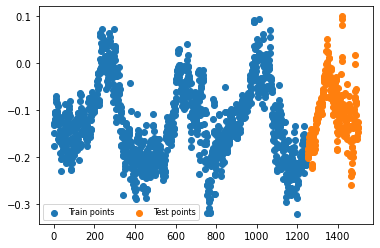

In [634]:
# Graph Our training and testing points
train_plt = plt.scatter(x_train, y_train)
test_plt = plt.scatter(x_test, y_test)
plt.legend((train_plt, test_plt),
           ('Train points', 'Test points'),
           loc='lower left',
           scatterpoints=1,
           ncol=3,
           fontsize=8)
plt.show()

In [635]:
# Calculate mean std of x and y variables
xtrain_mean = x_train.mean()
ytrain_mean = y_train.mean()

xtrain_std = x_train.std()
ytrain_std = y_train.std()

# Normalize training data
x_train = (x_train - x_train.mean()) / x_train.std()
y_train = (y_train - y_train.mean()) / y_train.std()

# Normalize testing data
x_test = (x_test - xtrain_mean) / xtrain_std
y_test = (y_test - ytrain_mean) / ytrain_std

# Full prediction
full_x = torch.cat((x_train, x_test))

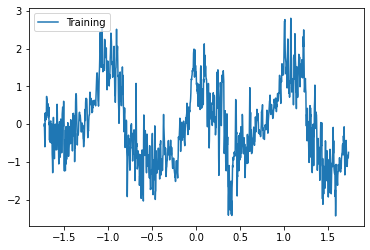

In [636]:
# Graph Our training and testing points
train_plt = plt.plot(x_train, y_train, label="Training")
plt.legend(loc="upper left")
plt.show()

In [637]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

hypers = {
    'covar_module.base_kernel.lengthscale': torch.tensor(4.2),
}

model.initialize(**hypers)

print(
    model.covar_module.base_kernel.lengthscale.item(),
)

4.199999809265137


In [638]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

In [639]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -0.3433822989463806
Parameter name: mean_module.constant                       value = -2.000492811203003
Parameter name: covar_module.raw_outputscale               value = 4.329548358917236
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -0.6009982824325562


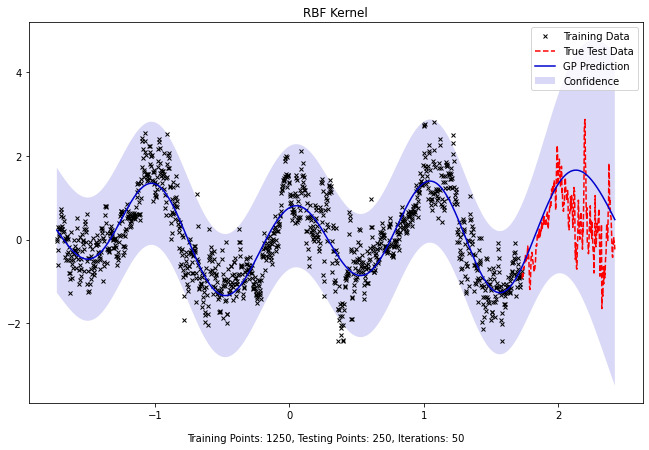

In [640]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    # Make predictions
    observed_pred_full = likelihood(model(full_x))
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(11, 7))
    
    # Get upper and lower confidence bounds
    lower_full, upper_full = observed_pred_full.confidence_region()

    # Plot training data as black x's
    ax.plot(x_train.numpy(), y_train.numpy(), 'x', color='black', markersize=4)
    
    # Plot test data as red line
    ax.plot(x_test.numpy(), y_test.numpy(), '--', color='red', lw=1.5)

    # Plot predictive means as blue line
    ax.plot(full_x.numpy(), observed_pred_full.mean.numpy(), 'mediumblue', lw=1.5)

    # Shade between the lower and upper confidence bounds
    ax.fill_between(full_x.numpy() , lower_full.numpy(), upper_full.numpy(), facecolor='mediumblue',alpha=0.15)

    ax.set_title("RBF Kernel")
    ax.legend(['Training Data', 'True Test Data', 'GP Prediction', 'Confidence'])
    caption= "Training Points: " + str(data_size-gap_size) + ", Testing Points: " + str(gap_size) +", Iterations: " + str(training_iter)
    f.text(.5, .05, caption, ha='center')